<a href="https://colab.research.google.com/github" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# **Music Genre Classification Project**

**Course**: Selected Topics in Music and Audio Engineering

**Topic**: Machine Learning for MusicEngineering

---
**Before you start**:
* Go to *File* → *Save a copy in Drive*
* Work on your copy of the notebook
---
## **1. Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle

from glob import glob
from tqdm import tqdm

import librosa, librosa.display
import IPython.display as ipd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier

plt.style.use("seaborn-v0_8")
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, TimeDistributed, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2


2025-06-10 11:46:54.115933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
## **2. Download Music and Dataset and set Path**

In [16]:
AUDIO_DIR = 'fma_small'
METADATA_PATH = 'fma_metadata/tracks.csv'

In [17]:
# 2) Getting mp3 files
audio_files = sorted(glob('fma_small/*/*.mp3'))

# From metadata, only track IDs blonging to fma_small are obtained
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0,1], index_col=0)
subset_small = tracks[('set','subset')] == 'small'
valid_ids = set(tracks[subset_small].index)
# From file names, get ID, discard the ones that are not in fma_small
df = pd.DataFrame([
    {'path': p, 'genre': tracks.loc[int(os.path.splitext(os.path.basename(p))[0]), ('track','genre_top')]}
    for p in audio_files
    if int(os.path.splitext(os.path.basename(p))[0]) in valid_ids
])
df.dropna(subset=['genre'], inplace=True)
df = df.reset_index(drop=True)

In [18]:
def extract_features(path, sr=22050):
    try:
        y, _ = librosa.load(path, sr=sr)
    except Exception as e:
        print(f"Can't load: {path} → {e}")
        return None

    y = np.nan_to_num(y)
    y = librosa.util.normalize(y)
    feats = []

    #### Rhythm features
    # Tempo (BPM)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
    feats.append(tempo)

    # Beat histogram
    tempo_hist = np.histogram(onset_env, bins=8, range=(0, np.max(onset_env)))[0]
    feats.extend(tempo_hist.tolist())

    # Extra for rmse - Root mean square energy
    rms = librosa.feature.rms(y=y)
    feats.append(rms.mean())
    feats.append(rms.std())

    #### Harmony features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    feats.extend(chroma.mean(axis=1).tolist())  # mean of each chroma bin
    feats.extend(chroma.std(axis=1).tolist())   # std of each chroma bin

    # extra for harmony - Tonnetz (tonal centroid features)
    try:
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        feats.extend(tonnetz.mean(axis=1).tolist())
        feats.extend(tonnetz.std(axis=1).tolist())
    except:
        feats.extend([0.0] * 12)  # 6 mean + 6 std in case of failure

    #### Timbre features
    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feats.extend(mfcc.mean(axis=1).tolist())
    feats.extend(mfcc.std(axis=1).tolist())

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    feats.extend(contrast.mean(axis=1).tolist())
    feats.extend(contrast.std(axis=1).tolist())

    # Extra for timbre - Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    feats.append(zcr.mean())
    feats.append(zcr.std())

    # Extra for timbre2 - Spectral bandwidth & centroid
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    feats.append(bandwidth.mean())
    feats.append(bandwidth.std())
    feats.append(centroid.mean())
    feats.append(centroid.std())

    return np.array(feats)


In [ ]:
# Preparing: the not working ones are passed
def prepare_X_y(df):
    X, ys = [], []
    for _, row in df.iterrows():
        feat = extract_features(row['path'])
        if feat is None:
            continue
        X.append(feat)
        ys.append(row['genre'])
    X = np.vstack(X)
    return X, ys, None

In [ ]:
df.head()

,path,genre
0,fma_small/000/000002.mp3,Hip-Hop
1,fma_small/000/000005.mp3,Hip-Hop
2,fma_small/000/000010.mp3,Pop
3,fma_small/000/000140.mp3,Folk
4,fma_small/000/000141.mp3,Folk


In [ ]:
# %70 train, %30 test (no validation this point, 30% test will be splitted to half in cnn later)
train_df, test_df_full = train_test_split(
    df,
    test_size=0.3,
    stratify=df['genre'],
    random_state=42
)

print("Data distribution (for Random Forest):")
print(f"Train set: {len(train_df)} samples")
print(f"Test set (will be split later for CNN): {len(test_df_full)} samples")


Data distribution (for Random Forest):
Train set: 5600 samples
Test set (will be split later for CNN): 2400 samples


In [ ]:
# TRAIN SET
X_train, y_train_raw, _ = prepare_X_y(train_df)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)

# TEST SET — only transform with the same encoder
X_test, y_test_raw, _ = prepare_X_y(test_df_full)
y_test = le.transform(y_test_raw)


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y,

❌ Can't load: fma_small/108/108925.mp3 → 


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa vers

❌ Can't load: fma_small/099/099134.mp3 → 


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


❌ Can't load: fma_small/133/133297.mp3 → 


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_

In [ ]:
# Save
if os.path.exists("X_train.npy") and os.path.exists("y_train.npy"):
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
else:
    X_train, y_train_raw, _ = prepare_X_y(train_df)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train_raw)
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y,

❌ Can't load: fma_small/108/108925.mp3 → 


/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:16: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/tv/c63r612s2fxb11kxtg30lh940000gn/T/ipykernel_66911/4042134071.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = libr

In [ ]:
import pickle
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

# LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

Saved: X_train.npy, y_train.npy, X_test.npy, y_test.npy, label_encoder.pkl


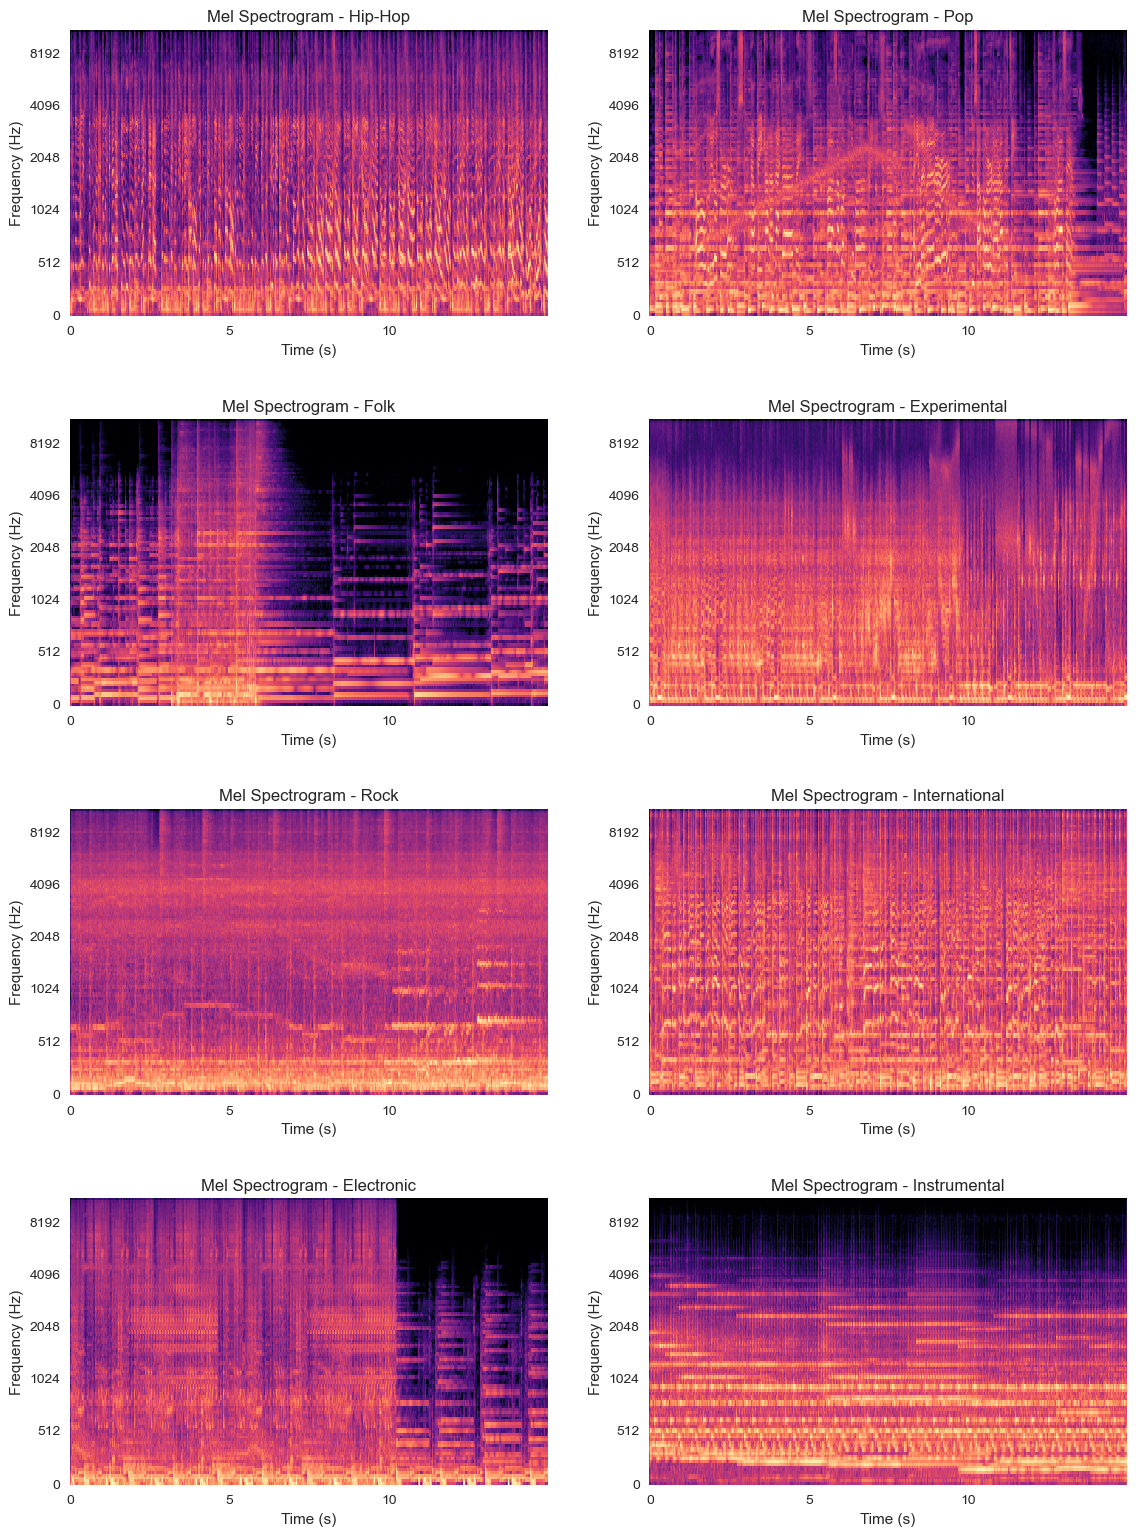

In [19]:
genres = df['genre'].unique()

# Matrix for 8 spectograms
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()

# Iterate over each genre to extract 1 spectogram
for i, genre in enumerate(genres):
    # random sample
    random_song_path = df[df['genre'] == genre].sample(1)['path'].iloc[0]
    
    try:
        y, sr = librosa.load(random_song_path, duration=30)
        
        # Calculate Mel
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        
        # Visualize
        librosa.display.specshow(mel_spect_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i])
        axs[i].set_title(f'Mel Spectrogram - {genre}', fontsize=12)
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Frequency (Hz)')

    except Exception as e:
        axs[i].set_title(f'Error loading {genre}: {e}', fontsize=9)

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

print(f'RandomForest - Train score: {np.round(rf_model.score(X_train_scaled, y_train), 4)}')
print(f'RandomForest - Test score: {np.round(rf_model.score(X_test_scaled, y_test), 4)}')

print("\n Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds, target_names=le.classes_))


RandomForest - Train score: 0.9998
RandomForest - Test score: 0.5392

 Random Forest Classification Report:

               precision    recall  f1-score   support

   Electronic       0.54      0.53      0.54       299
 Experimental       0.61      0.37      0.46       299
         Folk       0.55      0.66      0.60       300
      Hip-Hop       0.59      0.68      0.63       300
 Instrumental       0.56      0.61      0.58       300
International       0.57      0.60      0.59       300
          Pop       0.30      0.24      0.27       300
         Rock       0.56      0.62      0.59       300

     accuracy                           0.54      2398
    macro avg       0.53      0.54      0.53      2398
 weighted avg       0.53      0.54      0.53      2398



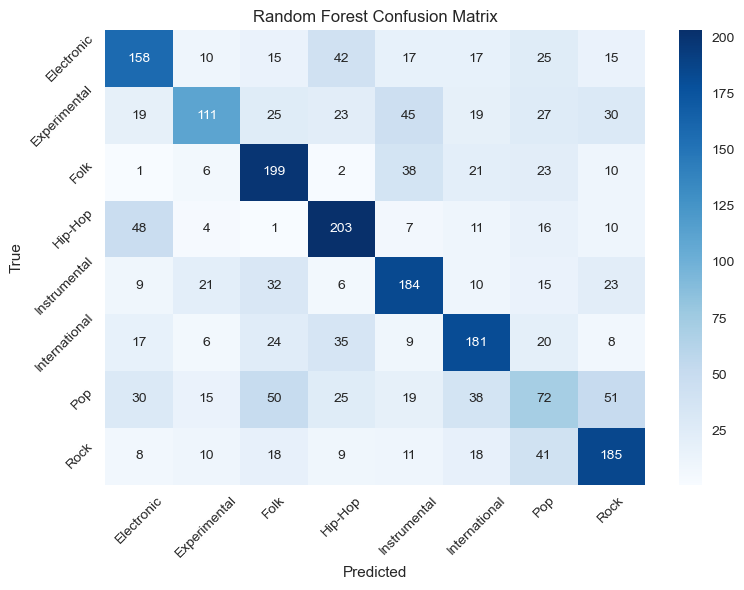

In [ ]:
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# SVM with RBF kernel
model_svm = SVC(kernel='rbf', gamma='scale')
model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)

print(f'SVM (with rbf) - Train score: {np.round(model_svm.score(X_train_scaled, y_train), 4)}')
print(f'SVM (with rbf) - Test score: {np.round(model_svm.score(X_test_scaled, y_test), 4)}')

print("\n SVM Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM (with rbf) - Train score: 0.743
SVM (with rbf) - Test score: 0.5613

 SVM Report:

               precision    recall  f1-score   support

   Electronic       0.54      0.56      0.55       299
 Experimental       0.50      0.46      0.48       299
         Folk       0.59      0.68      0.63       300
      Hip-Hop       0.63      0.67      0.65       300
 Instrumental       0.58      0.60      0.59       300
International       0.63      0.60      0.62       300
          Pop       0.37      0.28      0.31       300
         Rock       0.60      0.64      0.62       300

     accuracy                           0.56      2398
    macro avg       0.55      0.56      0.56      2398
 weighted avg       0.55      0.56      0.56      2398



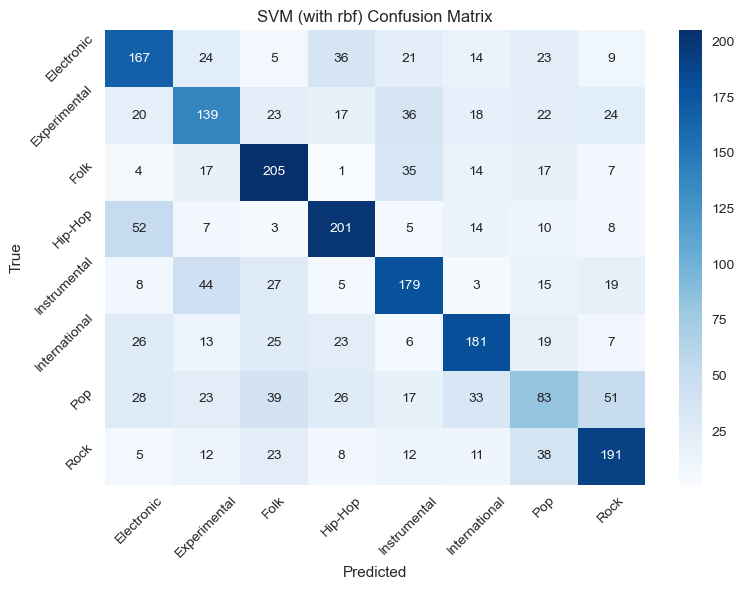

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM (with rbf) Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# MLP

In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

In [3]:
# Split test set into validation and final test (the 30% test before, now 15% val & 15% test)
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    stratify=y_test,
    random_state=42
)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_final = scaler.transform(X_test_final)

In [5]:
# Output
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_final_cat = to_categorical(y_test_final, num_classes)

In [6]:
modelmlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

modelmlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12032     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [7]:
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)]

modelmlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historymlp = modelmlp.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=200,
    validation_data=(X_val, y_val_cat),
    callbacks = callbacks
)

Epoch 1/100
28/28 [==============================] - 2s 13ms/step - loss: 2.6088 - accuracy: 0.1699 - val_loss: 1.8873 - val_accuracy: 0.3094 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 2.1913 - accuracy: 0.2493 - val_loss: 1.7500 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 2.0070 - accuracy: 0.2904 - val_loss: 1.6616 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 1.9203 - accuracy: 0.3217 - val_loss: 1.6011 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 1.8105 - accuracy: 0.3499 - val_loss: 1.5575 - val_accuracy: 0.4696 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 1.7561 - accuracy: 0.3667 - val_loss: 1.5247 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 1.

MLP Resume
Train loss:     0.9918
Train accuracy:   0.6646
Test loss:        1.2594
Test accuracy:    0.5721


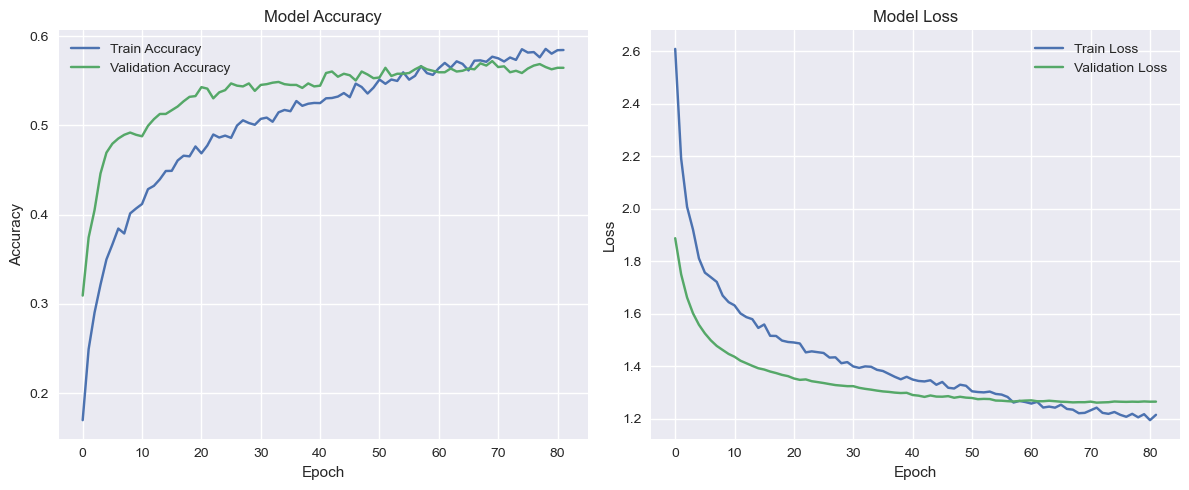

In [21]:
train_loss_mlp, train_acc_mlp = modelmlp.evaluate(X_train, y_train_cat, verbose=0)
test_loss_mlp, test_acc_mlp = modelmlp.evaluate(X_test_final, y_test_final_cat, verbose=0)

print("MLP Resume")
print(f"Train loss:     {train_loss_mlp:.4f}")
print(f"Train accuracy:   {train_acc_mlp:.4f}")
print(f"Test loss:        {test_loss_mlp:.4f}")
print(f"Test accuracy:    {test_acc_mlp:.4f}")

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historymlp.history['accuracy'], label='Train Accuracy')
plt.plot(historymlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(historymlp.history['loss'], label='Train Loss')
plt.plot(historymlp.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


38/38 [==============================] - 0s 1ms/step


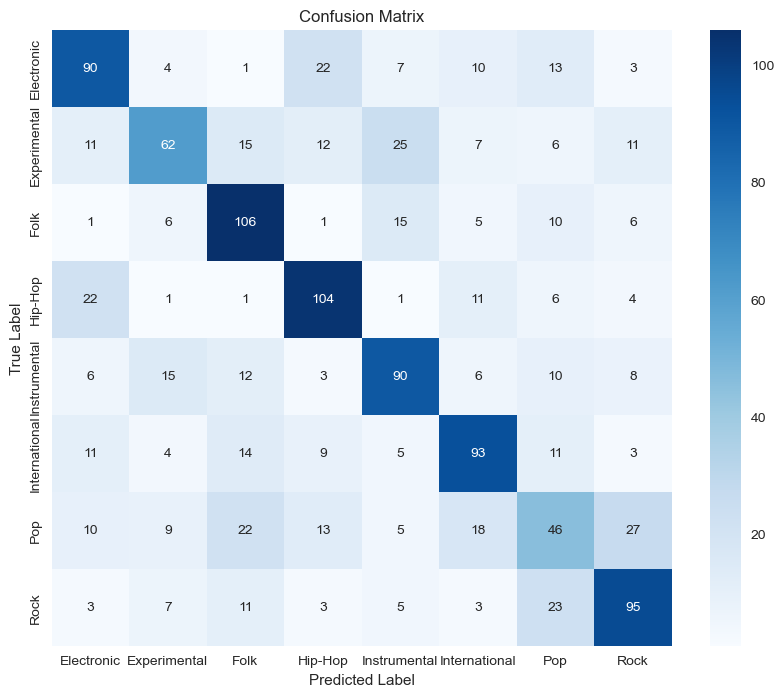

Classification Report:

               precision    recall  f1-score   support

   Electronic       0.58      0.60      0.59       150
 Experimental       0.57      0.42      0.48       149
         Folk       0.58      0.71      0.64       150
      Hip-Hop       0.62      0.69      0.66       150
 Instrumental       0.59      0.60      0.59       150
International       0.61      0.62      0.61       150
          Pop       0.37      0.31      0.33       150
         Rock       0.61      0.63      0.62       150

     accuracy                           0.57      1199
    macro avg       0.57      0.57      0.57      1199
 weighted avg       0.57      0.57      0.57      1199



In [13]:
y_pred_probs = modelmlp.predict(X_test_final)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test_final, y_pred, target_names=le.classes_))

# CNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 21, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 2688)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

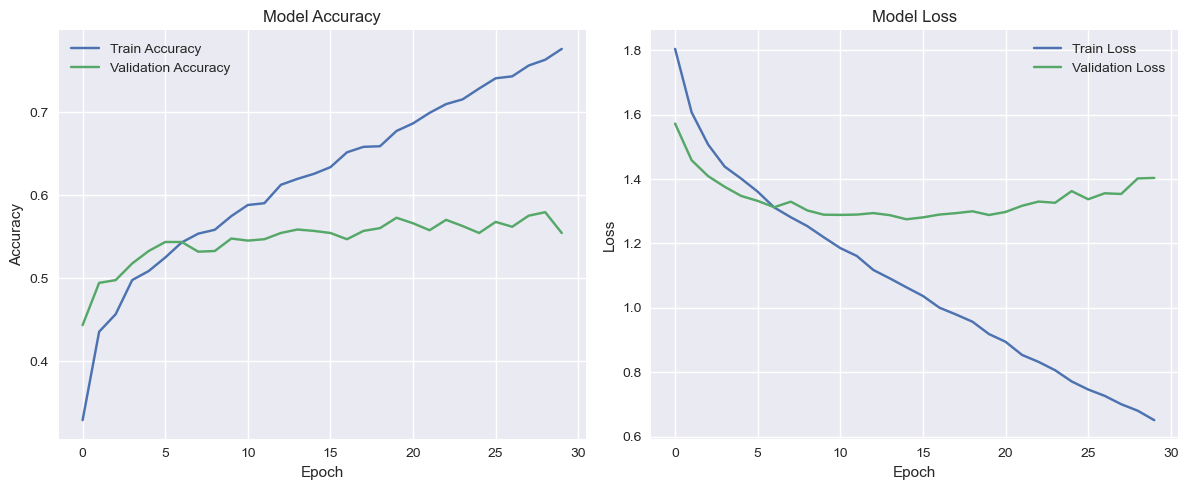

38/38 [==============================] - 0s 3ms/step


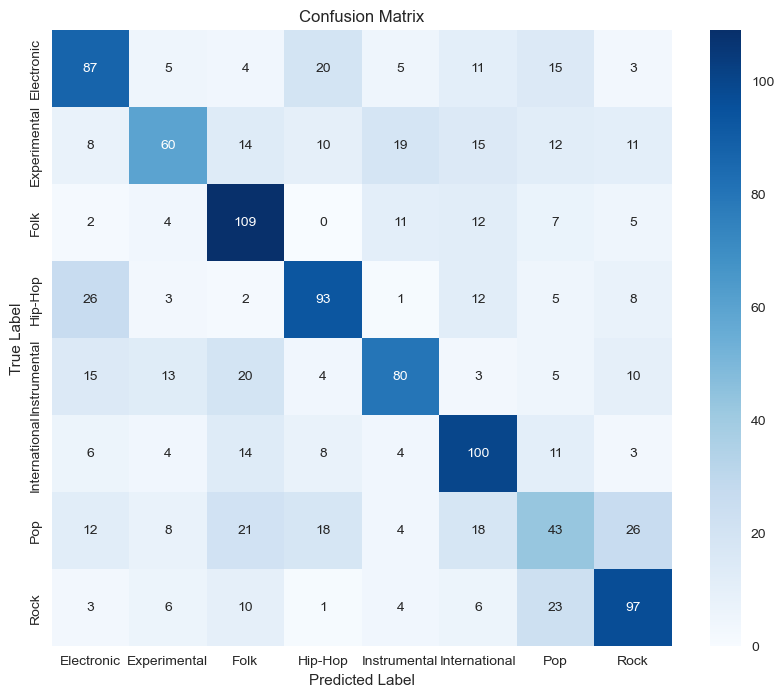

Classification Report:

               precision    recall  f1-score   support

   Electronic       0.55      0.58      0.56       150
 Experimental       0.58      0.40      0.48       149
         Folk       0.56      0.73      0.63       150
      Hip-Hop       0.60      0.62      0.61       150
 Instrumental       0.62      0.53      0.58       150
International       0.56      0.67      0.61       150
          Pop       0.36      0.29      0.32       150
         Rock       0.60      0.65      0.62       150

     accuracy                           0.56      1199
    macro avg       0.55      0.56      0.55      1199
 weighted avg       0.55      0.56      0.55      1199



In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_final = scaler.transform(X_test_final)

# reshape for cnn model
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test_final.reshape((X_test_final.shape[0], X_test_final.shape[1], 1))


model_cnn1d = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(np.unique(y_train)), activation='softmax')
])

model_cnn1d.summary()

model_cnn1d.compile(optimizer=Adam(learning_rate=0.0003),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

history_cnn1d = model_cnn1d.fit(X_train_cnn, y_train,
                                epochs=150,
                                batch_size=32,
                                validation_data=(X_val_cnn, y_val),
                                callbacks=[
                                    EarlyStopping(patience=15, restore_best_weights=True)
                                ])


# Accuracy result on test set
test_loss, test_acc = model_cnn1d.evaluate(X_test_cnn, y_test_final)
print("Final test accuracy:", test_acc)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn1d.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn1d.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn1d.history['loss'], label='Train Loss')
plt.plot(history_cnn1d.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


y_pred_probs = model_cnn1d.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test_final, y_pred, target_names=le.classes_))


In [23]:
train_loss_cnn, train_acc_cnn = model_cnn1d.evaluate(X_train_cnn, y_train, verbose=0)
test_loss_cnn, test_acc_cnn = model_cnn1d.evaluate(X_test_cnn, y_test_final, verbose=0)

print("1D-CNN Resume")
print(f"Train loss:     {train_loss_cnn:.4f}")
print(f"Train accuracy:   {train_acc_cnn:.4f}")
print(f"Test loss:        {test_loss_cnn:.4f}")
print(f"Test accuracy:    {test_acc_cnn:.4f}")

1D-CNN Resume
Train loss:     0.9065
Train accuracy:   0.7007
Test loss:        1.2884
Test accuracy:    0.5580
